In [ ]:
import pandas as pd
import torch

In [ ]:
df = pd.read_csv('voice.csv')
df

In [ ]:
x = df.values[:, :-1]
x = torch.tensor(x.astype('float32'))
y = df.values[:, -1]
print('y', y)
y[y == 'male'] = 0
y[y == 'female'] = 1
print('y', y)
y = torch.tensor(y.astype('float32'))

In [ ]:
from torch.utils.data import random_split, DataLoader, Dataset

In [ ]:
class TensorDataset(Dataset):
    def __init__(self, *tensors, mu, std):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.mu = mu
        self.std = std

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = (x - self.mu) / self.std
        y = self.tensors[1][index]
        return (x, y)

    def __len__(self):
        return self.tensors[0].size(0)

In [ ]:
train_size = round(len(x) * 0.7)
test_size = len(x) - train_size
train_idx, test_idx = random_split(range(len(x)), [train_size, test_size])
mu = x[train_idx].mean(dim=0)
std = x[train_idx].std(dim=0)

In [ ]:
dataset_train = TensorDataset(x[train_idx], y[train_idx], mu=mu, std=std)
dataset_test = TensorDataset(x[test_idx], y[test_idx], mu=mu, std=std)

In [ ]:
print('train', len(dataset_train))
print('test', len(dataset_test))

In [ ]:
batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [19]:
from torch import nn

latent_dim = 5

class VoiceEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, latent_dim),
        )
    
    def forward(self, x):
        return self.encoder(x)

class VoiceDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 20),
        )
    
    def forward(self, x):
        return self.decoder(x)

class VoiceAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VoiceEncoder()
        
        w_layers = [nn.Linear(latent_dim, latent_dim, bias=False) for _ in range(2)]
        self.w_layers = nn.Sequential(*w_layers)
        
        self.decoder = VoiceDecoder()

    def forward(self, x):
        encode = self.encoder(x)
        z = self.w_layers(encode)
        return self.decoder(z)

In [20]:
device = torch.device('cuda:2')
model = VoiceAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [21]:
# # test model
# test_x = torch.rand(16, 20).to(device)
# model(test_x).shape

In [22]:
from tqdm import tqdm
def train(model, data, epoch, criterion, optimizer, device, is_tqdm=False):
    model.train()
    loss_list = []
    acc_count = 0

    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, _) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch).squeeze() # predict the label
        loss = criterion(recon, batch) # calculate error
        loss_list.append(loss.item())
        
        loss.backward()  # back-propagation
        optimizer.step() # gradient descent

    return sum(loss_list) / len(loss_list)

def test(model, data, criterion, device, is_tqdm=False):
    model.eval()
    loss_list = []

    acc_count = 0
    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, _) in loader:
        batch = batch.to(device)

        recon = model(batch).squeeze()
        loss = criterion(recon, batch)
        loss_list.append(loss.item())

    return sum(loss_list) / len(loss_list)

In [23]:
# ckpt = torch.load('ckpts/irmae_dim5.pt')
# model.load_state_dict(ckpt)
# print(test(model, train_data, criterion, device))
# print(test(model, test_data, criterion, device))

0.12441876253911427
0.11845431973536809


In [14]:
import matplotlib.pyplot as plt

class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.val_loss_list = []
    
    def update(self, train_loss, val_loss):
        self.train_loss_list.append(train_loss)
        self.val_loss_list.append(val_loss)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()

In [15]:
from torch.optim.lr_scheduler import StepLR

max_epoch = 280
step_size = 70
log_interval = 20

scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)

meter = Meter()

for epoch in range(1, max_epoch + 1):
    if epoch % log_interval == 0:
        tqdm.write('==========Train Epoch {}=========='.format(epoch))
    train_loss = train(model, train_data, epoch, criterion, optimizer, device)
    test_loss = test(model, test_data, criterion, device)
    scheduler.step()
    
    meter.update(train_loss, test_loss)
    
    if epoch % log_interval == 0:
        print('Train loss: {:.04f} - Test loss: {:.04f}'.format(
            train_loss, test_loss,
        ))

==========Train Epoch 20==========
Train loss: 0.2712 - Test loss: 0.2373
==========Train Epoch 40==========
Train loss: 0.2453 - Test loss: 0.2207
==========Train Epoch 60==========
Train loss: 0.2242 - Test loss: 0.2086
==========Train Epoch 80==========
Train loss: 0.2187 - Test loss: 0.1894
==========Train Epoch 100==========
Train loss: 0.2165 - Test loss: 0.1919
==========Train Epoch 120==========
Train loss: 0.2149 - Test loss: 0.1856
==========Train Epoch 140==========
Train loss: 0.2076 - Test loss: 0.1865
==========Train Epoch 160==========
Train loss: 0.2134 - Test loss: 0.1828
==========Train Epoch 180==========
Train loss: 0.2064 - Test loss: 0.1821
==========Train Epoch 200==========
Train loss: 0.2045 - Test loss: 0.1874
==========Train Epoch 220==========
Train loss: 0.1985 - Test loss: 0.1804
==========Train Epoch 240==========
Train loss: 0.2054 - Test loss: 0.1791
==========Train Epoch 260==========
Train loss: 0.2029 - Test loss: 0.1797
==========Train Epoch 280====

In [20]:
(1365 + 1231 + 1699) / 3

1431.6666666666667

Train loss: 0.1575 - Test loss: 0.1365  
Train loss: 0.1522 - Test loss: 0.1231  
Train loss: 0.2027 - Test loss: 0.1799

In [16]:
# x_ = dataset_train[0][0].to(device).unsqueeze(0)
# recon = model(x_).detach()
# print(recon)
# print(x_)

In [17]:
# torch.save(model.state_dict(), 'ckpts/irmae_dim5.pt')

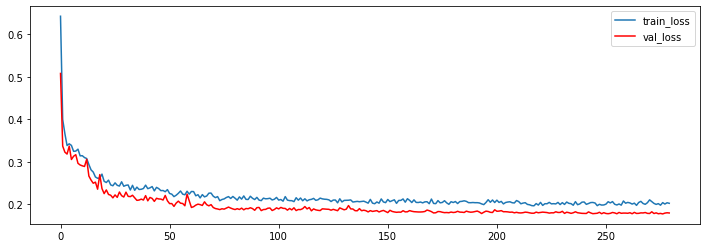

In [18]:
meter.plot()